# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure OpenAI Configuration
AOAI_ENDPOINT=your_azure_openai_endpoint
AOAI_KEY=your_azure_openai_api_key
AOAI_API_VERSION=2024-02-01  # Optional, defaults to this value

# Model Deployment Names
reasoningModel=your_reasoning_model_deployment_name  # e.g., o1-preview
chatModel=your_chat_model_deployment_name  # e.g., gpt-4o

# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Bing Search Agent (pre-created in Azure AI Foundry)
bingSearchAgentID=your_bing_search_agent_id
BING_CONNECTION_NAME=your_bing_connection_name  # Only needed if creating agent inline
```

**Note:** This notebook creates agents inline using the OpenAI Agents SDK, except for the Bing Search agent which must be pre-created in Azure AI Foundry. If you haven't created the Bing Search agent yet, uncomment and run the agent creation cell below.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating the Bing Search Agent (One-time Setup)

The following cell will **create** an **Azure AI Agent** with Bing Search capabilities. You only need to run this cell **once** to create the agent, then save its ID to your `.env` file as `bingSearchAgentID`.

If you already have a Bing Search agent created, skip this cell and use the next cell to update its instructions instead.

In [5]:
# from azure.ai.agents.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
# You are a helpful research assistant.

# Today's date is {current_date}.

# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results.
#     """.strip()
# )

### Updating Existing Bing Search Agent

If you already have a Bing Search agent (with its ID in your `.env` file), run this cell to update its instructions with today's date. This ensures the agent has current date awareness for time-sensitive queries.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-11-10.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


### Creating OpenAI Agents

The following agents are created inline using the OpenAI Agents SDK. These agents handle planning, summarization, research synthesis, and peer review. They are created fresh each time you run the notebook.

In [7]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)


**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

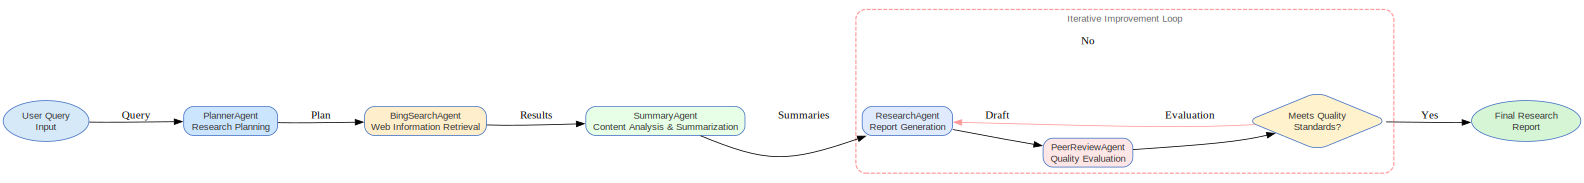

In [9]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'What is deep learning?',
 'What is generative AI?',
 'Fundamental concepts of classical ML, deep learning, and generative AI',
 'Overview of machine learning paradigms']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [13]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [07:20<00:00, 88.02s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 23

Actually total search queries: 23



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [15]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [01:43<00:00, 20.73s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [16]:
plan.final_output

ResearchPlan(query='What are the differences between classical machine learning, deep learning and generative AI?', objective='To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their fundamental differences in terms of concepts, methodologies, applications, strengths, and limitations.', success_criteria=['Clear definitions and explanations of classical machine learning, deep learning, and generative AI are provided.', 'Key differences between the three approaches are identified and explained across multiple dimensions (e.g., architecture, data requirements, interpretability, etc.).', 'Examples of real-world applications for each approach are included.', 'Comparative analysis includes strengths and weaknesses of each method.', 'References to authoritative sources or recent research are incorporated.'], related_topics=['Neural network architectures', 'Transfer learning', 'Explainable AI'], research_tasks=[ResearchTask(id=Non

In [17]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [18]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [19]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI

## Introduction

Artificial intelligence (AI) has evolved into a multifaceted discipline encompassing a range of methodologies, each tailored to specific types of data, tasks, and problem domains. Among the most prominent paradigms are classical machine learning (ML), deep learning (DL), and generative AI (GenAI). These approaches, while interconnected, differ fundamentally in their conceptual underpinnings, architectural designs, data requirements, training processes, applications, and interpretability. This report provides an exceptionally comprehensive, paragraph-focused analysis of these three AI pillars, drawing on recent research and authoritative sources to elucidate their distinctions, strengths, limitations, and industry impact. The discussion is organized into five broad thematic sections: Definitions and Fundamental Concepts, Architectural and Methodological Differences, Data Requirements and Training Processes, Applications and Use Cases, and Strengths, Limitations, and Interpretability. Data visualizations are included where appropriate to enhance understanding.

## 1. Definitions and Fundamental Concepts

The landscape of artificial intelligence is shaped by the interplay between classical machine learning, deep learning, and generative AI, each defined by unique algorithms, data paradigms, and conceptual frameworks. Classical machine learning represents the foundational layer of AI, relying on statistical models and manual feature engineering to extract patterns from structured data. Algorithms such as linear regression, logistic regression, decision trees, support vector machines (SVM), and k-nearest neighbors (KNN) exemplify this paradigm. These models are designed to generalize from training data, enabling predictions or decisions without explicit programming for every scenario. Central to classical ML are concepts like supervised learning (mapping labeled inputs to outputs), unsupervised learning (discovering patterns in unlabeled data), and reinforcement learning (agents learning optimal actions through environmental feedback). The discipline is further characterized by principles such as overfitting, bias-variance trade-off, and the use of model evaluation metrics including accuracy, precision, recall, and cross-validation [1][2][3][4][5][6].

Deep learning, a specialized branch of machine learning, is distinguished by its use of multi-layered artificial neural networks. Inspired by the architecture of the human brain, these networks consist of interconnected artificial neurons organized into input, hidden, and output layers. Deep learning models automatically learn hierarchical representations and features from raw, often unstructured data such as images, text, or audio, thereby eliminating the need for manual feature engineering. Key concepts include activation functions (ReLU, sigmoid, tanh), backpropagation for error minimization, and specialized architectures: convolutional neural networks (CNNs) for image tasks, recurrent neural networks (RNNs) and long short-term memory (LSTM) units for sequential data, and transformers for natural language processing. Deep learning excels in handling massive datasets and complex tasks, powering applications like image recognition, speech recognition, autonomous vehicles, and advanced natural language processing. However, it requires significant computational resources and large-scale data for effective training [7][8][9][10][11][12][13][14][15][16][17][18][19].

Generative AI marks a transformative leap, focusing on the creation of new data instances—text, images, audio, video, or code—using advanced generative models such as generative adversarial networks (GANs), variational autoencoders (VAEs), diffusion models, and large language models (LLMs) like GPT. Unlike traditional discriminative models that classify or predict, generative AI models invent novel instances within the learned statistical boundaries of their training data. GANs employ a generator-discriminator pair to produce realistic synthetic data, VAEs encode data into a latent space for new sample generation, and transformers generate coherent text by autoregressively predicting sequences. Generative AI systems act as collaborators, producing outputs ranging from realistic images and deepfake videos to human-like conversations and original music compositions. Their rapid advancement raises important social, ethical, and legal questions, including concerns about originality, bias, data privacy, and the anthropomorphic perception of machine creativity [20][21][22][23][24][25][26][27][28][29].

All three subfields are underpinned by the foundational paradigms of machine learning: supervised learning (learning from labeled data for prediction), unsupervised learning (discovering patterns in unlabeled data), and reinforcement learning (learning optimal actions through interaction and feedback). Semi-supervised, self-supervised, and transfer learning further extend these paradigms to address challenges such as limited labeled data or domain adaptation. The fundamental components of machine learning algorithms—datasets, cost functions, optimization procedures, and parameterized models—are common across classical ML, deep learning, and generative AI, though their implementation and complexity vary [5][30][31].

### Comparative Overview

A comparative overview highlights the distinctions: classical ML is best suited for structured data and interpretable models with manual feature extraction; deep learning thrives on unstructured data and automatic feature learning via deep architectures; generative AI leverages deep and adversarial networks to synthesize new data, pushing the boundaries of machine creativity. The historical trajectory of these fields reflects advances in computational power, algorithmic innovation, and the availability of large-scale data, with deep learning and generative AI driving recent breakthroughs in AI capabilities [32][33][34][35][36][37][38][39].

### Hierarchical Breakdown of AI Paradigms

| Paradigm         | Core Algorithms/Architectures | Data Type         | Feature Engineering | Output Type         |
|------------------|------------------------------|-------------------|---------------------|---------------------|
| Classical ML     | Regression, SVM, Trees, KNN  | Structured        | Manual              | Predictive          |
| Deep Learning    | CNN, RNN, LSTM, Transformer  | Unstructured      | Automatic           | Predictive          |
| Generative AI    | GAN, VAE, Transformer (LLM)  | Multimodal        | Automatic           | Generative          |

## 2. Architectural and Methodological Differences

The architectural and methodological differences among classical machine learning, deep learning, and generative AI are central to their respective capabilities, applications, and limitations. Classical ML algorithms are characterized by shallow architectures, typically consisting of one or two layers. These models require extensive manual feature engineering, where domain experts select and preprocess relevant features from structured data. This manual process is crucial for model performance but is time-consuming and demands domain expertise. The resulting models are generally interpretable and transparent, allowing for straightforward debugging and explanation, which is particularly valuable in fields like fraud detection, medical diagnosis, and predictive analytics. Training classical ML models is computationally efficient, suitable for small to medium-sized datasets, and typically does not require specialized hardware [40][41][42][43][44][45].

Deep learning, in contrast, is defined by its use of multi-layered artificial neural networks—hence the term "deep." Architectures such as convolutional neural networks (CNNs) for image data, recurrent neural networks (RNNs) and their variants (LSTM, GRU) for sequential data, and transformers for natural language processing (NLP) automatically learn hierarchical feature representations from raw, unstructured data. This automation of feature extraction eliminates much of the need for manual intervention, enabling DL models to excel in complex tasks like image recognition, speech processing, and autonomous driving. However, this power comes at the cost of increased computational demands; training deep networks requires large datasets and advanced hardware (GPUs/TPUs). The complexity of these architectures also leads to reduced interpretability, often rendering them "black boxes" whose decision-making processes are difficult to explain. Despite these challenges, DL has become indispensable for processing vast amounts of unstructured data and is increasingly integrated into advanced analytics and automation workflows [46][47][48][49][50][51][52][53][54][55].

Generative AI represents a further evolution, leveraging deep learning frameworks to create new, original content. Architectures such as GANs, VAEs, and transformer-based models (e.g., GPT, DALL·E) are designed to learn complex data distributions and synthesize realistic outputs—be it text, images, audio, or even video. GANs use a generator-discriminator framework to iteratively improve the quality of synthetic data, while transformers handle massive sequential datasets for tasks like language modeling and multimodal content generation. Methodologically, generative AI often operates in unsupervised or self-supervised modes, learning from unlabeled or semi-structured data and focusing on creative synthesis rather than mere prediction. This enables generative AI to augment traditional ML training sets, facilitate ideation in design workflows, and produce outputs that go beyond classification or regression [56][57][58][59][60][61][62][63].

### Methodological Distinctions

The methodological differences are as pronounced as the architectural ones. Classical ML is primarily predictive, mapping inputs to outputs using supervised learning and requiring labeled data. Its transparency and repeatability make it suitable for high-precision, regulated environments. Deep learning automates feature learning and is capable of handling complex, unstructured data, but its models are less interpretable and require substantial data and computational resources. Generative AI shifts the paradigm from prediction to creation, generating new data samples that resemble the training data and handling multimodal inputs. While generative AI is revolutionizing fields like architecture, design, and content creation, its outputs are often raster images or non-editable objects, with only a minority producing CAD/BIM-ready geometry. Integration into professional workflows remains fragmented, with technical, cultural, and ecosystem barriers limiting mainstream adoption [64][65][66][67][68][69][70][71].

### Comparison Table: Architectural and Methodological Features

| Feature               | Classical ML        | Deep Learning        | Generative AI         |
|-----------------------|--------------------|----------------------|-----------------------|
| Architecture          | Shallow (1–2 layers)| Deep (multi-layered) | Deep + Adversarial/Transformers |
| Feature Engineering   | Manual             | Automatic            | Automatic             |
| Data Type             | Structured         | Unstructured         | Multimodal            |
| Output                | Predictive         | Predictive           | Generative            |
| Interpretability      | High               | Medium–Low           | Low                   |
| Computational Demand  | Low                | High                 | Very High             |

## 3. Data Requirements and Training Processes

The data requirements and training processes for classical machine learning, deep learning, and generative AI reflect a continuum of complexity, scale, and resource demands. Classical ML stands out for its data efficiency and interpretability. Algorithms such as decision trees, linear regression, and SVMs typically operate on structured, tabular datasets, often requiring only thousands to tens of thousands of labeled examples. The training process is characterized by a sequence of well-defined steps: data cleaning, normalization, feature selection or engineering, algorithm selection, model fitting, and validation. Feature engineering is particularly critical, as these models depend on manually crafted features to capture underlying patterns. Classical ML models are transparent and easier to troubleshoot, making them suitable for domains where interpretability and modest data volumes are paramount, such as finance and healthcare. Computationally, classical ML can be trained on standard hardware—dual or quad-core CPUs, 8–16GB RAM, and moderate storage (100GB+), with optional GPU acceleration for larger datasets or more complex models [72][73][74][75][76][77][78][79][80].

Deep learning models, including CNNs, RNNs, and Transformers, require orders of magnitude more data—often millions of labeled, unstructured examples (images, text, audio)—to generalize effectively and avoid overfitting. The complexity of these architectures, with their many layers and parameters, necessitates vast data to learn hierarchical representations. Training processes automate feature extraction, feeding raw data into multi-layered neural networks. This process is computationally intensive, relying on GPUs or TPUs for parallelized matrix operations and advanced optimization techniques like backpropagation and gradient descent. Deep learning workflows involve data augmentation, architecture selection (e.g., ResNet, Transformer), hyperparameter tuning (learning rates, batch sizes, network depth), and rigorous evaluation using metrics such as loss and accuracy. Deployment often requires converting models to efficient formats (ONNX, TensorFlow Lite). Hardware requirements escalate: quad-core or higher CPUs, 16–32GB RAM, 500GB+ storage, and dedicated GPUs (NVIDIA RTX 3090/4090 or A100). For large-scale projects, cloud resources and distributed training are essential [81][82][83][84][85][86][87][88][89][90][91][92].

Generative AI models, such as GANs, VAEs, and large language models (LLMs) like GPT, push data and resource requirements to their limits. These models demand hundreds of millions to billions of diverse, high-quality examples to learn the underlying structure and distribution of data, enabling them to generate realistic and contextually accurate outputs. Data preprocessing for generative AI involves large-scale cleaning, deduplication, and filtering to ensure diversity and mitigate bias. Training utilizes advanced architectures—GANs employ a generator-discriminator framework, while Transformers leverage massive parallel processing and sequence modeling. The process is highly resource-intensive, often requiring distributed training across many GPUs/TPUs, huge memory (128–512GB RAM), and extensive storage (1–20TB for datasets, 500GB–2TB+ for checkpoints). High-speed networking (10Gbps+, NVLink/Infiniband) is crucial for synchronizing distributed workloads. Training costs can range from $15,000–$30,000 for a 7B/8B parameter LLM to $500,000–$1,000,000 for a 70B parameter model on 1 trillion tokens. Fine-tuning, while less demanding than full training, still requires substantial resources and is often used to adapt pre-trained models to specific domains [93][94][95][96][97][98][99].

### Data Requirements Comparison Table

| Paradigm      | Typical Dataset Size        | Data Type        | Feature Engineering | Hardware Needs         | Training Cost (Est.) |
|---------------|----------------------------|------------------|---------------------|------------------------|----------------------|
| Classical ML  | 1,000–50,000               | Structured       | Manual              | CPU, 8–16GB RAM        | Low                  |
| Deep Learning | 1,000,000+                 | Unstructured     | Automatic           | GPU/TPU, 16–32GB RAM   | Moderate–High        |
| Generative AI | 100,000,000–1,000,000,000+ | Multimodal       | Automatic           | Distributed GPU/TPU, 128–512GB RAM, 10TB+ Storage | Very High            |

### Impact of Data Quality and Resource Management

Across all approaches, the impact of dataset size and quality is profound. Classical ML models reach a plateau where additional data yields diminishing returns, while deep learning and generative AI benefit from ever-larger and more diverse datasets, though with increasing computational costs. Data scarcity in deep learning and generative AI is addressed through techniques like transfer learning, self-supervised learning, and synthetic data generation. The diversity and cleanliness of data are as important as volume, as they influence model robustness and generalization. Resource management and optimization are critical, especially for generative AI and large-scale deep learning. Efficient infrastructure allocation, use of resource schedulers (e.g., SLURM), and cloud computing solutions help maximize utilization and reduce bottlenecks, though cost and data confidentiality remain concerns. Developers must balance dataset size, data quality, model complexity, and computational resources to optimize training outcomes [100][101][102][103][104][105].

## 4. Applications and Use Cases

The landscape of artificial intelligence applications is defined by three major paradigms—classical machine learning, deep learning, and generative AI—each offering distinct strengths and use cases across industries. Classical machine learning, rooted in statistical algorithms such as decision trees, logistic regression, support vector machines, and Naive Bayes, is particularly effective for structured data problems where interpretability, efficiency, and robustness are paramount. Its applications span image and video recognition (e.g., face detection, object recognition), natural language processing (sentiment analysis, spam filtering), anomaly detection (fraud in finance, cybersecurity breaches, equipment failure monitoring), healthcare (disease diagnosis, patient risk assessment), finance (credit scoring, risk evaluation, regulatory compliance), process automation (quality control, predictive maintenance), and predictive modeling (customer segmentation, price estimation, sales forecasting). Classical ML models are favored for their ability to deliver clear reasoning, perform well with small or structured datasets, and operate at lower computational cost, making them suitable for resource-constrained environments and regulatory contexts [106][107][108][109][110][111][112][113][114][115][116].

Deep learning, leveraging multi-layered artificial neural networks such as convolutional neural networks (CNNs) and recurrent neural networks (RNNs), excels in processing large volumes of unstructured data—images, audio, and text—unlocking high accuracy and enabling machines to perceive and interpret complex patterns. In computer vision, deep learning powers image recognition, segmentation, and object detection, with applications in medical imaging (tumor detection), biometric authentication, smart home security, and autonomous vehicles (real-time sensor interpretation for self-driving cars). In natural language processing, deep learning underpins speech recognition (virtual assistants, transcription), text analysis (sentiment analysis, translation, summarization), and chatbots. Healthcare benefits from deep learning in medical imaging diagnostics, drug discovery (simulating molecular interactions), and personalized medicine (tailoring treatments based on genetics and lifestyle). Additional use cases include recommendation systems (personalized content on platforms like Netflix and Amazon), cybersecurity (threat detection), scientific research (large dataset analysis in genomics and climate science), entertainment (image/video enhancement, game playing via deep reinforcement learning), and precision agriculture (optimizing crop yields using sensor and satellite data). While deep learning delivers superior performance for complex tasks, it demands substantial computational resources and large annotated datasets [117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138].

Generative AI, epitomized by models like GPT-4, DALL-E, and Stable Diffusion, is redefining automation and creativity by generating entirely new content—text, images, music, code, and synthetic data—based on learned patterns. In content creation and media, GenAI automates the production of marketing copy, blog posts, legal documents, and technical reports, as well as generating realistic images, music, and videos for rapid prototyping and creative workflows. In healthcare and life sciences, GenAI accelerates drug discovery (designing new compounds, simulating molecular interactions), enhances medical imaging diagnostics, supports personalized medicine, and produces synthetic data for clinical trials. Software development benefits from AI-powered coding assistants (e.g., GitHub Copilot X, Tabnine) that suggest code, fix bugs, and automate routine tasks. Business process automation is streamlined in HR, finance, and operations, while customer experience is elevated through AI-driven chatbots, personalized recommendations, and real-time translation and summarization. GenAI also optimizes supply chain management (demand forecasting, logistics simulation), accelerates scientific research (AI-driven reasoning, synthetic data generation), transforms education (automated content generation, AI tutors), and revolutionizes design and engineering (product and architectural design, simulation and testing) [139][140][141][142][143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160].

### Impact Assessment Matrix: AI Paradigms Across Industries

| Industry         | Classical ML Applications    | Deep Learning Applications      | Generative AI Applications      |
|------------------|-----------------------------|---------------------------------|---------------------------------|
| Healthcare       | Risk assessment, diagnosis   | Medical imaging, drug discovery | Synthetic data, personalized medicine |
| Finance          | Credit scoring, fraud detection | Risk modeling, anomaly detection | Automated reporting, scenario simulation |
| Manufacturing    | Quality control, predictive maintenance | Defect detection, robotics      | Design automation, simulation   |
| Media/Content    | Sentiment analysis, recommendation | Image/video enhancement         | Automated content creation      |
| Retail           | Customer segmentation, price prediction | Recommendation systems          | Personalized marketing, product design |
| Scientific Research | Data analysis, modeling    | Genomics, climate modeling       | Synthetic data generation, hypothesis testing |

### Adoption Trends and Future Outlook

Industry adoption trends underscore the growing integration of these technologies. Nearly 90% of organizations report using AI in some capacity, with the majority still in early stages—piloting or experimenting with ML, DL, and GenAI in specific business functions rather than full enterprise-wide deployment. High-performing companies prioritize growth and innovation, redesigning workflows to harness AI’s transformative potential. Generative AI, in particular, is viewed by 64% of senior data leaders as the most transformative technology of the generation, with projections suggesting it could unlock trillions in economic value by 2030 [161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180].

## 5. Strengths, Limitations, and Interpretability

The landscape of artificial intelligence is shaped by the strengths, limitations, and interpretability characteristics of classical machine learning, deep learning, and generative AI. These factors are crucial for determining their suitability across various domains, especially those requiring transparency and reliability.

Classical machine learning encompasses algorithms such as linear regression, logistic regression, decision trees, support vector machines, and random forests. These models are foundational in AI and remain widely used for structured data and well-defined tasks. Their primary strengths lie in simplicity, ease of implementation, and low computational requirements, making them accessible for small organizations and projects. Classical ML models are highly interpretable; for instance, linear regression provides direct insight into feature importance via coefficients, and decision trees allow for clear visualization of decision pathways. This transparency is vital in regulated industries like healthcare and finance, where stakeholders must understand and trust model decisions for regulatory compliance and ethical accountability [181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199].

Feature engineering in classical ML is both a strength and a limitation. It enables domain experts to inject specialized knowledge, potentially improving model performance when relevant features are carefully crafted. However, this process is manual, labor-intensive, and demands substantial expertise. Classical ML models also perform well with limited data, making them suitable when large labeled datasets are unavailable. Despite these advantages, classical ML is restricted in adaptability, struggles with scalability in high-dimensional or large datasets, and often underperforms on complex tasks involving unstructured data (e.g., images, audio, text). Additionally, these models do not learn from their environment unless explicitly retrained, limiting their ability to adapt to new data or evolving scenarios.

Deep learning revolutionizes AI by automating feature extraction and enabling hierarchical representation learning. Neural networks, including convolutional (CNNs) and recurrent architectures (RNNs), can process massive, complex, and unstructured datasets, achieving state-of-the-art performance in image classification, speech recognition, and machine translation. Deep learning models are robust, generalize well to unseen data with sufficient training, and are highly adaptable across diverse applications. However, these strengths come at the cost of immense data and computational requirements—training often necessitates high-performance GPUs and large labeled datasets, making deep learning resource-intensive and less practical for small-scale or resource-constrained environments.

A major limitation of deep learning is its lack of interpretability. The intricate architectures and vast numbers of parameters render these models “black boxes,” making it difficult to trace how specific decisions are made. This opacity poses challenges for trust, transparency, and regulatory compliance, particularly in critical domains. While research in explainable AI (XAI) has produced techniques such as feature visualization, attention mechanisms, and surrogate models, full interpretability remains elusive. Deep learning models are also susceptible to overfitting, especially with insufficient data or poor regularization, and are sensitive to data quality, potentially amplifying biases or errors present in training datasets [200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219].

Generative AI builds on deep learning to create novel content—text, images, code—through models like GPT, DALL-E, and Stable Diffusion. Its strengths include automating creative and repetitive tasks, enabling new forms of human-AI interaction, and generating contextually relevant outputs at scale. However, generative AI faces unique limitations. Non-determinism leads to unpredictable outputs, undermining reliability in high-stakes environments. Hallucinations, where models produce convincing but false information, pose significant risks in domains requiring factual accuracy. Generative AI also struggles with deep contextual understanding and complex reasoning, limiting its effectiveness for nuanced or ethical decision-making.

Bias and data dependency are critical concerns; generative models can inherit and amplify biases from training data, resulting in unfair or discriminatory outputs. Privacy and security risks arise when models inadvertently reproduce sensitive or proprietary information. Most notably, interpretability in generative AI is even lower than in deep learning—understanding why a specific output was generated is challenging due to the complexity of model architectures and training data. This lack of transparency complicates error analysis, trust, and regulatory compliance.

### Comparative Interpretability and Strengths Table

| Paradigm      | Strengths                   | Limitations                  | Interpretability |
|---------------|-----------------------------|------------------------------|------------------|
| Classical ML  | Interpretable, efficient, suitable for structured data | Limited scalability, manual feature engineering, poor performance on complex/unstructured data | High             |
| Deep Learning | Automatic feature extraction, high accuracy on complex data | Resource-intensive, “black box” models, sensitive to data quality | Medium–Low       |
| Generative AI | Creative automation, novel data generation, scalable outputs | Low reliability, bias, ethical challenges, poor interpretability | Very Low         |

### Implications and Open Questions

The strengths of ML, DL, and GenAI enable transformative automation, efficiency, and performance across industries. However, their limitations—especially around interpretability, bias, resource requirements, and ethical deployment—must be carefully managed. Addressing these challenges is essential for responsible AI adoption. Ongoing research in explainable AI, bias mitigation, and robust engineering practices will be critical for maximizing benefits while minimizing risks, particularly as AI systems become more deeply integrated into decision-making processes that affect individuals and society at large.

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a rich tapestry of methodologies, each with distinct conceptual foundations, architectural designs, data requirements, training processes, applications, and interpretability profiles. Classical ML offers interpretable, efficient solutions for structured data and well-defined tasks, making it indispensable in regulated and resource-constrained environments. Deep learning excels in processing unstructured data and automating feature extraction, driving breakthroughs in computer vision, speech recognition, and natural language processing, albeit with significant resource demands and reduced transparency. Generative AI, built on deep learning, is revolutionizing creative industries and scientific research through the synthesis of novel content, but faces challenges in reliability, bias, and ethical deployment. The interplay between these paradigms continues to shape the evolution of artificial intelligence, with ongoing research addressing scalability, interpretability, and responsible use. As organizations and researchers advance from pilot projects to scaled adoption, the full potential of AI to transform industries and unlock new opportunities is becoming increasingly evident. The choice among classical ML, deep learning, and generative AI depends on the nature of the data, the complexity of the task, and the desired balance between interpretability, accuracy, and creativity. Understanding these distinctions is essential for selecting the appropriate approach and maximizing the impact of artificial intelligence in the modern world.

## References

[1] Generative AI Fundamentals: A Comprehensive Guide for 2025, https://www.toolify.ai/ai-news/generative-ai-fundamentals-a-comprehensive-guide-for-2025-3812143
[2] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[3] Chapter 1 - Classical Machine Learning, https://mcklay.github.io/classical-machine-learning/chapter1/
[4] Generative Artificial Intelligence: A Concept in Progress, https://link.springer.com/article/10.1007/s13347-025-00875-8
[5] Machine Learning Paradigms - Introduction to Machine Learning - Wolfram, https://www.wolfram.com/language/introduction-machine-learning/machine-learning-paradigms/
[6] (PDF) Fundamental Concepts of Machine Learning - Academia.edu, https://www.academia.edu/77079038/Fundamental_Concepts_of_Machine_Learning
[7] What Is Deep Learning? | Microsoft Azure, https://azure.microsoft.com/en-us/resources/cloud-computing-dictionary/what-is-deep-learning/
[8] A comprehensive overview of Generative AI (GAI): Technologies ..., https://www.sciencedirect.com/science/article/pii/S0925231225003170
[9] What is Generative AI (GenAI)? Definition, How It Works, Applications ..., https://www.sciencenewstoday.org/what-is-generative-ai-genai-definition-how-it-works-applications-and-future-impact
[10] Core Concepts of Machine Learning (classical) | GRAUSOFT, https://grausoft.net/core-concepts-of-machine-learning/
[11] Generative AI: Definition, Concepts, Applications, and ... - Authorea, https://www.techrxiv.org/users/765209/articles/1016725-generative-ai-definition-concepts-applications-and-future-prospects
[12] Machine Learning Fundamentals Handbook – Key Concepts, Algorithms, and ..., https://www.freecodecamp.org/news/machine-learning-handbook/
[13] What Is Deep Learning? Definition, Examples, and Careers, https://www.coursera.org/articles/what-is-deep-learning
[14] Deep Learning: Foundations and Concepts: by Christopher M. Bishop and ..., https://www.tandfonline.com/doi/pdf/10.1080/14697688.2024.2436137
[15] The Fundamental Concepts Behind Deep Learning, https://www.researchgate.net/profile/Abu-Rayhan-11/publication/373650869_The_Fundamental_Concepts_Behind_Deep_Learning/links/64f601dc48c07f3da3d86bf7/The-Fundamental-Concepts-Behind-Deep-Learning.pdf?origin=publication_detail
[16] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/artificial-intelligence/difference-between-machine-learning-and-deep-learning/
[17] Machine Learning and Deep Learning Paradigms: From Techniques to ..., https://www.mdpi.com/2073-431X/14/3/93
[18] Deep Learning: Foundations and Concepts | SpringerLink, https://link.springer.com/book/10.1007/978-3-031-45468-4
[19] Deep Learning 101 - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/deep-learning-101/
[20] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning
[21] Machine Learning and Deep Learning: A Comparative Review, https://link.springer.com/chapter/10.1007/978-981-33-6307-6_15
[22] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[23] Understanding the Differences Between AI, ML, DL, GenAI, and LLM, https://galaxy.ai/youtube-summarizer/understanding-the-differences-between-ai-ml-dl-genai-and-llm-uUcUBeiAHcs
[24] Shaping Architecture with Generative Artificial Intelligence: Deep ..., https://www.mdpi.com/2673-8945/5/4/94
[25] Deep learning vs. classic machine learning: differences you should know ..., https://iartificial.blog/en/learning/Deep-learning-vs.-classic-machine-learning%3A-differences-you-should-know/
[26] The role of artificial intelligence (AI) in architectural design: a ..., https://link.springer.com/article/10.1007/s43995-025-00186-1
[27] Data differences between generative AI and traditional ML, https://docs.aws.amazon.com/prescriptive-guidance/latest/strategy-data-considerations-gen-ai/differences.html
[28] Generative AI vs Traditional AI - GeeksforGeeks, https://www.geeksforgeeks.org/blogs/difference-between-generative-ai-and-traditional-ai/
[29] A Comprehensive Overview and Comparative Analysis on Deep Learning ..., https://arxiv.org/abs/2305.17473
[30] Deep Learning vs Machine Learning: Key Differences, https://labelyourdata.com/articles/deep-learning-vs-machine-learning
[31] 03. Key Differences Between Traditional Machine Learning (ML) and ..., https://veritasautomata.com/insights/thought-leadership/key-differences-machine-learning-generative-artificial-intelligence/
[32] Generative AI for Architectural Design: A Literature Review, https://arxiv.org/html/2404.01335v1
[33] Deep Learning vs. Traditional Machine Learning: What’s the Difference ..., https://makez.ai/deep-learning-vs-traditional-machine-learning-whats-the-difference/
[34] A Comparative Analysis of Machine Learning Algorithms for ..., https://www.sciencedirect.com/science/article/pii/S1877050922021159
[35] A survey on deep learning tools dealing with data scarcity: definitions ..., https://journalofbigdata.springeropen.com/articles/10.1186/s40537-023-00727-2
[36] Train AI and ML models - Azure Databricks | Microsoft Learn, https://learn.microsoft.com/en-us/azure/databricks/machine-learning/train-model/
[37] What is the significance of dataset size in machine learning model ..., https://milvus.io/ai-quick-reference/what-is-the-significance-of-dataset-size-in-machine-learning-model-performance
[38] Impact of Dataset Size on Deep Learning Model - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/impact-of-dataset-size-on-deep-learning-model/
[39] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[40] A Comparative Study of Machine Learning Algorithms on Datasets of ..., https://link.springer.com/chapter/10.1007/978-3-031-73125-9_16
[41] What are the minimum computing resources needed to train a machine ..., https://ai.stackexchange.com/questions/5981/what-are-the-minimum-computing-resources-needed-to-train-a-machine-learning-algo
[42] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[43] AI and machine learning tutorials - Databricks on AWS, https://docs.databricks.com/aws/en/machine-learning/ai-ml-tutorials
[44] 13 Important Data Science System Requirements - GeeksforGeeks, https://www.geeksforgeeks.org/data-science/13-important-data-science-system-requirements/
[45] Optimizing Computational Resources for Machine Learning and Data ..., https://deepsense.ai/blog/optimizing-computational-resources-for-machine-learning-and-data-science-projects-a-practical-approach/
[46] Guide to Hardware Requirements for Training and Fine-Tuning Large ..., https://towardsai.net/p/artificial-intelligence/guide-to-hardware-requirements-for-training-and-fine-tuning-large-language-models
[47] Generative AI vs Traditional AI - GeeksforGeeks, https://www.geeksforgeeks.org/blogs/difference-between-generative-ai-and-traditional-ai/
[48] Why Classical Machine Learning Still Matters in a ... - transorg.ai, https://www.transorg.ai/blog/why-classical-machine-learning-still-matters-in-a-generative-ai-world/
[49] 5 Reasons Why Traditional Machine Learning is Alive and Well in the Age ..., https://machinelearningmastery.com/5-reasons-why-traditional-machine-learning-is-alive-and-well-in-the-age-of-llms/
[50] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[51] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[52] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/research/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies-IJERTV13IS050275.pdf
[53] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[54] Deep Learning Examples: Practical Applications in Real Life, https://www.geeksforgeeks.org/deep-learning/deep-learning-examples/
[55] The State of AI: Global Survey 2025 | McKinsey, https://www.mckinsey.com/capabilities/quantumblack/our-insights/the-state-of-ai
[56] Machine learning and generative AI: What are they good for in 2025?, https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-and-generative-ai-what-are-they-good-for
[57] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/
[58] Generative AI Use Cases 2025 | Real Applications Explained, https://futurense.com/blog/gen-ai-use-cases
[59] Top 41 Deep Learning Use Cases & Examples in 2025, https://www.marketingscoop.com/ai/deep-learning-applications/
[60] Top 8 Generative AI Applications in 2025 - e2enetworks.com, https://www.e2enetworks.com/blog/top-8-generative-ai-applications-in-2025
[61] The Evolution of Generative AI: Trends and Applications, https://ieeexplore.ieee.org/document/11016906
[62] Overview of Machine Learning Part 1: Fundamentals and Classic ..., https://www.sciencedirect.com/science/article/pii/S1052514920300629
[63] Top 41 Deep Learning Use Cases & Examples in 2025 - ExpertBeacon, https://expertbeacon.com/deep-learning-applications/
[64] Top Generative AI Applications and Products in 2025 - Datasumi, https://en.datasumi.com/top-generative-ai-applications-and-products-in-2025
[65] Top 50 Deep Learning Use Case & Case Studies - AIMultiple, https://research.aimultiple.com/deep-learning-applications/
[66] Modern AI: GenAI vs Machine Learning vs Deep Learning vs LLMs - Cloud4C, https://www.cloud4c.com/blogs/genai-vs-machine-learning-vs-deep-learning-vs-llms
[67] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html
[68] 10 Generative AI Use Cases Transforming Industries in 2025, https://www.digitalocean.com/resources/articles/generative-ai-use-cases
[69] AI vs ML vs DL vs Generative AI: A Comparison | Synoptek, https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/
[70] Challenges with developing and deploying AI models and applications in ..., https://link.springer.com/article/10.1007/s44163-024-00151-2
[71] Some Common Limitations of Generative AI (2025) - PyNet Labs, https://www.pynetlabs.com/limitations-of-generative-ai/
[72] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[73] Understanding The Limitations Of Generative AI, https://www.forbes.com/councils/forbestechcouncil/2024/05/09/understanding-the-limitations-of-generative-ai/
[74] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[75] A Survey on Large Language Models: Applications, Challenges ..., https://www.techrxiv.org/doi/full/10.36227/techrxiv.23589741.v1
[76] 5 Advantages and Disadvantages of Deep Learning - RF Wireless World, https://www.rfwireless-world.com/terminology/deep-learning-advantages-disadvantages
[77] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/
[78] The Pros and Cons of Deep Learning - eWeek, https://www.eweek.com/artificial-intelligence/deep-learning-pros-cons/
[79] Challenges in Deploying Large Language Models - IT Convergence, https://www.itconvergence.com/blog/how-to-address-common-challenges-while-deploying-generative-ai-llms/
[80] Deep Learning: Advantages And Disadvantages You Need To Know, https://atrara.org/blog/deep-learning-advantages-and-disadvantages
[81] The Grand AI Handbook, https://grandaihandbook.github.io/content/handbooks/explainable-ai/
[82] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies
[83] On the Challenges and Opportunities in Generative AI, https://arxiv.org/html/2403.00025v3
[84] Interpretability research of deep learning: A literature survey, https://www.sciencedirect.com/science/article/pii/S1566253524004998
[85] Advantages and Disadvantages of Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/advantages-and-disadvantages-of-deep-learning/
[86] AI vs ML vs Deep Learning vs GenAI — The Cloud Girl, https://www.thecloudgirl.dev/blog/ai-vs-machine-learning-vs-deep-learning-vs-generative-ai
[87] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/
[88] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [20]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their fundamental differences in terms of concepts, methodologies, applications, strengths, and limitations.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Fundamental Concepts",
      "summary": "## Key Insights\n- Classical machine learning, deep learning, and generative AI are distinct yet interconnected subfields within artificial intelligence, each defined by their unique algorithms, data requirements, and fundamental concepts.\n- Classical machine learning relies on statistical models and manual feature engineering, excelling with structured data and interpretable algorithms, while deep learning